<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/MicrocontrollerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d tannergi/microcontroller-detection
    !unzip -qq microcontroller-detection.zip
    !rm microcontroller-detection.zip

Saving kaggle.json to kaggle.json
  0% 0.00/8.34M [00:00<?, ?B/s]
100% 8.34M/8.34M [00:00<00:00, 138MB/s]


In [4]:
from torch_snippets import *
from PIL import Image
from sklearn.utils import shuffle
import albumentations as A
import matplotlib

In [5]:
train = pd.read_csv('/content/MicrocontrollerDetection/train_labels.csv')
test = pd.read_csv('/content/MicrocontrollerDetection/test_labels.csv')

In [6]:
train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_20181228_101826.jpg,800,600,Arduino_Nano,317,265,556,342
1,IMG_20181228_101855.jpg,800,600,Heltec_ESP32_Lora,398,243,592,382
2,IMG_20181228_101903.jpg,800,600,ESP8266,290,239,514,387
3,IMG_20181228_101915.jpg,800,600,Raspberry_Pi_3,194,200,669,531
4,IMG_20181228_102013.jpg,800,600,Arduino_Nano,383,336,591,444
...,...,...,...,...,...,...,...,...
165,IMG_20190104_165129.jpg,800,600,ESP8266,240,255,530,418
166,IMG_20190104_165139.jpg,800,600,Arduino_Nano,306,300,457,464
167,IMG_20190104_165146.jpg,800,600,ESP8266,156,226,453,416
168,IMG_20190104_165200.jpg,800,600,Raspberry_Pi_3,288,220,696,559


In [7]:
label2target = {l:t+1 for t,l in enumerate(train['class'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [8]:
label2target

{'Arduino_Nano': 1,
 'ESP8266': 3,
 'Heltec_ESP32_Lora': 2,
 'Raspberry_Pi_3': 4,
 'background': 0}

In [9]:
label2target['Arduino_Nano']

1

In [10]:
train['class_id'] = train['class'].apply(lambda x: label2target[x])
test['class_id'] = test['class'].apply(lambda x: label2target[x])

In [11]:
train

,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
0,IMG_20181228_101826.jpg,800,600,Arduino_Nano,317,265,556,342,1
1,IMG_20181228_101855.jpg,800,600,Heltec_ESP32_Lora,398,243,592,382,2
2,IMG_20181228_101903.jpg,800,600,ESP8266,290,239,514,387,3
3,IMG_20181228_101915.jpg,800,600,Raspberry_Pi_3,194,200,669,531,4
4,IMG_20181228_102013.jpg,800,600,Arduino_Nano,383,336,591,444,1
...,...,...,...,...,...,...,...,...,...
165,IMG_20190104_165129.jpg,800,600,ESP8266,240,255,530,418,3
166,IMG_20190104_165139.jpg,800,600,Arduino_Nano,306,300,457,464,1
167,IMG_20190104_165146.jpg,800,600,ESP8266,156,226,453,416,3
168,IMG_20190104_165200.jpg,800,600,Raspberry_Pi_3,288,220,696,559,4


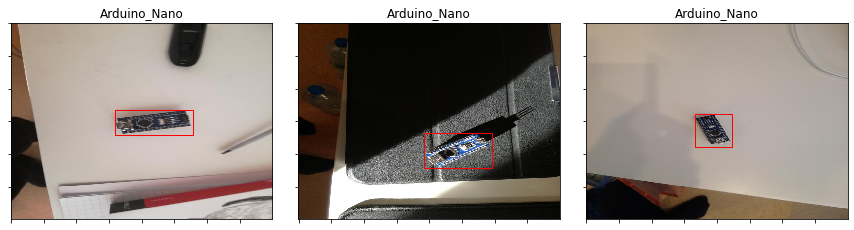

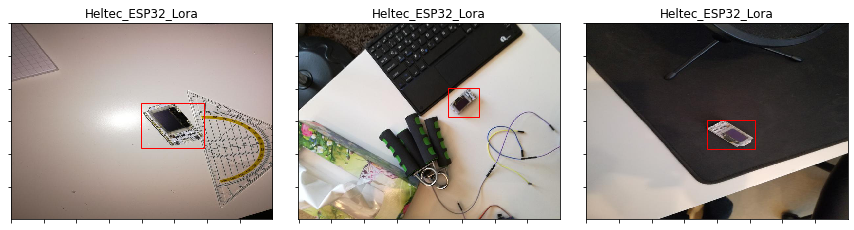

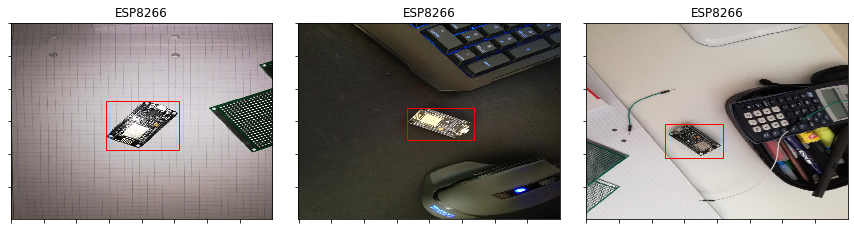

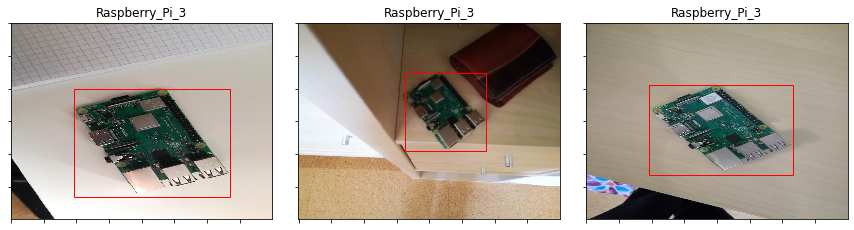

In [12]:
def plot_example(idx_list):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(3):
        image_id = train.loc[idx_list[i], 'filename']
        dim0 = train.loc[idx_list[i], 'width']
        dim1 = train.loc[idx_list[i], 'height']
        img = Image.open('/content/MicrocontrollerDetection/train/'+image_id)
        axs[i].imshow(img,cmap = plt.cm.gray, interpolation ='nearest')
        axs[i].set_title(train.loc[idx_list[i], 'class'])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if train.loc[idx_list[i], 'class'] != 'No finding':
            bbox = [(train.loc[idx_list[i], 'xmin']),
                    (train.loc[idx_list[i], 'ymin']),
                    (train.loc[idx_list[i], 'xmax']),
                    (train.loc[idx_list[i], 'ymax'])]
            p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                              bbox[2]-bbox[0],
                                              bbox[3]-bbox[1],
                                              ec='r', fc='none', lw=1.)
            axs[i].add_patch(p)
            
for num in range(1, 5):
    idx_list = train[train['class_id']==num][0:3].index.values
    plot_example(idx_list)

In [13]:
def update_bboxes(df):
    
    df['xmin'] = ((df['xmin'] / df['width'])).astype('float')
    df['ymin'] = ((df['ymin'] / df['height'])).astype('float')
    df['xmax'] = ((df['xmax'] / df['width'])).astype('float')
    df['ymax'] = ((df['ymax'] / df['height'])).astype('float')
    
    return df

In [14]:
train = update_bboxes(train)
test = update_bboxes(test)

In [64]:
train

,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
0,IMG_20181228_101826.jpg,800,600,Arduino_Nano,0.39625,0.441667,0.69500,0.570000,1
1,IMG_20181228_101855.jpg,800,600,Heltec_ESP32_Lora,0.49750,0.405000,0.74000,0.636667,2
2,IMG_20181228_101903.jpg,800,600,ESP8266,0.36250,0.398333,0.64250,0.645000,3
3,IMG_20181228_101915.jpg,800,600,Raspberry_Pi_3,0.24250,0.333333,0.83625,0.885000,4
4,IMG_20181228_102013.jpg,800,600,Arduino_Nano,0.47875,0.560000,0.73875,0.740000,1
...,...,...,...,...,...,...,...,...,...
165,IMG_20190104_165129.jpg,800,600,ESP8266,0.30000,0.425000,0.66250,0.696667,3
166,IMG_20190104_165139.jpg,800,600,Arduino_Nano,0.38250,0.500000,0.57125,0.773333,1
167,IMG_20190104_165146.jpg,800,600,ESP8266,0.19500,0.376667,0.56625,0.693333,3
168,IMG_20190104_165200.jpg,800,600,Raspberry_Pi_3,0.36000,0.366667,0.87000,0.931667,4


In [15]:
test

,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
0,IMG_20181228_102636.jpg,800,600,ESP8266,0.39500,0.341667,0.58125,0.521667,3
1,IMG_20181228_102641.jpg,800,600,Heltec_ESP32_Lora,0.50125,0.418333,0.69125,0.675000,2
2,IMG_20181228_102658.jpg,800,600,Arduino_Nano,0.23000,0.216667,0.77250,0.550000,1
3,IMG_20181228_102706.jpg,800,600,Raspberry_Pi_3,0.29125,0.228333,0.80000,0.786667,4
4,IMG_20181228_102745.jpg,800,600,Heltec_ESP32_Lora,0.24375,0.225000,0.76125,0.610000,2
5,IMG_20181228_102749.jpg,800,600,Arduino_Nano,0.19750,0.298333,0.67500,0.620000,1
6,IMG_20181228_102757.jpg,800,600,ESP8266,0.33250,0.358333,0.82250,0.738333,3


In [74]:
def preprocess_image(img):
    img = torch.tensor(img/255).permute(2,0,1)
    return img.to(device).float()

In [86]:
class microData(torch.utils.data.Dataset):
  def __init__(self, df, image_dir=None, transforms=None):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'*')
    self.df = df
    self.image_infos = df.filename.unique()
    self.transforms = transforms

  def __getitem__(self, ix):
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data = self.df[self.df['filename'] == image_id].reset_index(drop=True)

    if data.loc[0, "class_id"] == 0:
      data = data.loc[[0], :]
    boxes = data[['xmin','ymin', 'xmax', 'ymax']].values
    area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    labels = data['class_id'].values
    boxes[:,[0,2]] *= 300
    boxes[:,[1,3]] *= 300
    boxes = boxes.astype(np.uint32).tolist()

    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.tensor(labels, dtype=torch.int64)
    target["image_id"] = torch.tensor([ix])
    target['area'] = torch.tensor(area, dtype=torch.float32)
    target['iscrowd'] = torch.zeros(labels.shape[0], dtype=torch.int64)
        
    if self.transforms:
        sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels}
        
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])

    if target["boxes"].shape[0] == 0:
        # Albumentation cuts the target (class 14, 1x1px in the corner)
        target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 300.0, 300.0]]))
        target["area"] = torch.tensor([1.0], dtype=torch.float32)
        target["labels"] = torch.tensor([0], dtype=torch.int64)    

    img = preprocess_image(image)

    return img, target
  def collate_fn(self, batch):
    return tuple(zip(*batch))
  
  def __len__(self):
    return len(self.image_infos)

In [87]:
train_transform = A.Compose(
    [A.Resize(300,300),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RandomCrop(height=224, width=224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

val_transform = A.Compose(
    [A.Resize(300,300),
        #A.CenterCrop(height=224, width=224),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

In [88]:
train_ds = microData(train, image_dir = "/content/MicrocontrollerDetection/train/", transforms = train_transform)
test_ds = microData(test, image_dir = "/content/MicrocontrollerDetection/test/",transforms = val_transform)

train_loader = DataLoader(train_ds, batch_size=3, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=3, collate_fn=test_ds.collate_fn, drop_last=True)

In [89]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [90]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    images, targets = inputs
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    images, targets = inputs
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [96]:
model = get_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                             weight_decay=0.0005)
n_epochs = 10
log = Report(n_epochs)

In [97]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//10)==0: log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.361	trn_loc_loss: 0.183	trn_regr_loss: 0.161	trn_objectness_loss: 0.014	trn_rpn_box_reg_loss: 0.004	val_loss: 0.270	val_loc_loss: 0.155	val_regr_loss: 0.092	val_objectness_loss: 0.018	val_rpn_box_reg_loss: 0.005	(35.29s - 317.59s remaining)
EPOCH: 2.000	trn_loss: 0.199	trn_loc_loss: 0.107	trn_regr_loss: 0.087	trn_objectness_loss: 0.002	trn_rpn_box_reg_loss: 0.002	val_loss: 0.244	val_loc_loss: 0.116	val_regr_loss: 0.118	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.004	(66.50s - 266.00s remaining)
EPOCH: 3.000	trn_loss: 0.162	trn_loc_loss: 0.086	trn_regr_loss: 0.073	trn_objectness_loss: 0.001	trn_rpn_box_reg_loss: 0.003	val_loss: 0.184	val_loc_loss: 0.082	val_regr_loss: 0.076	val_objectness_loss: 0.020	val_rpn_box_reg_loss: 0.005	(96.90s - 226.11s remaining)
EPOCH: 4.000	trn_loss: 0.144	trn_loc_loss: 0.069	trn_regr_loss: 0.071	trn_objectness_loss: 0.001	trn_rpn_box_reg_loss: 0.002	val_loss: 0.141	val_loc_loss: 0.060	val_regr_loss: 0.065	val_objectness_loss:

100%|██████████| 111/111 [00:00<00:00, 6896.38it/s]


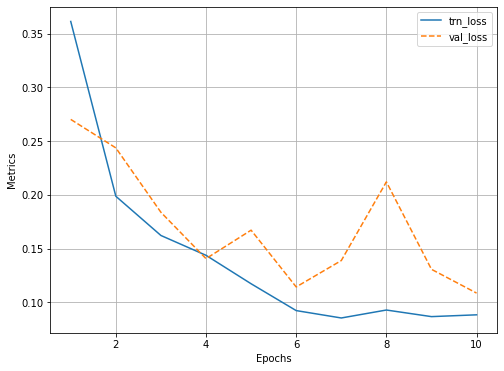

In [98]:
log.plot_epochs(['trn_loss','val_loss'])

In [99]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint32)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


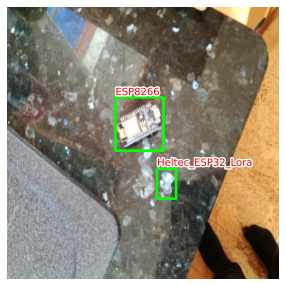

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


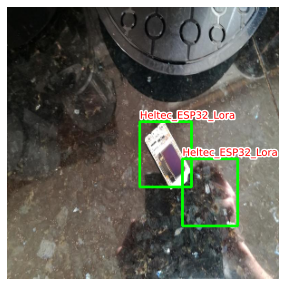

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


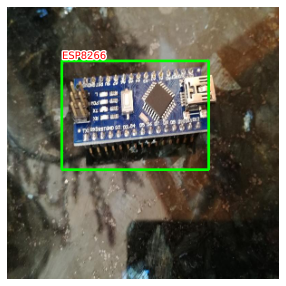

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


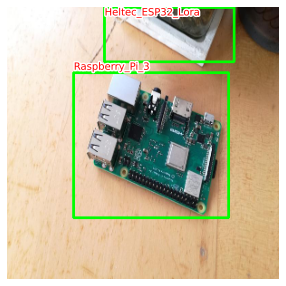

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


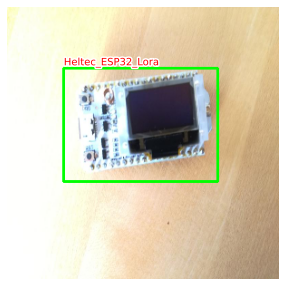

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


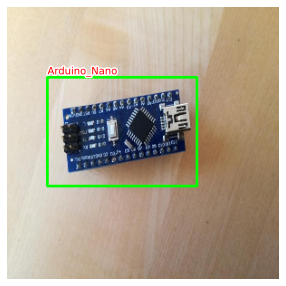

In [103]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==6: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)